## link dataset from kaggle 

<a href = "https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis"> dataset </a>

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (3.8.3)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Requirement already up-to-date: keras in /opt/conda/lib/python3.7/site-packages (2.4.3)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 6.7 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.3
    Uninstalling pandas-1.1.3:
      Successfully uninstalled pandas-1.1.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### read dataset

<h1> Dataset details¶ </h1>

1- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2- ids: The id of the tweet ( 2087)

3- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4- flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5- user: the user that tweeted (robotickilldozr)

6- text: the text of the tweet (Lyx is cool)

In [ ]:

dataset_path = "../input/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<h1> data analysis step </h1>


<h1> 1- Map target label to String to know 3 categories </h1>


0 -> NEGATIVE

2 -> NEUTRAL

4 -> POSITIVE

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))



In [ ]:
df.head(2)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


Text(0.5, 1.0, 'Dataset labels distribuition')

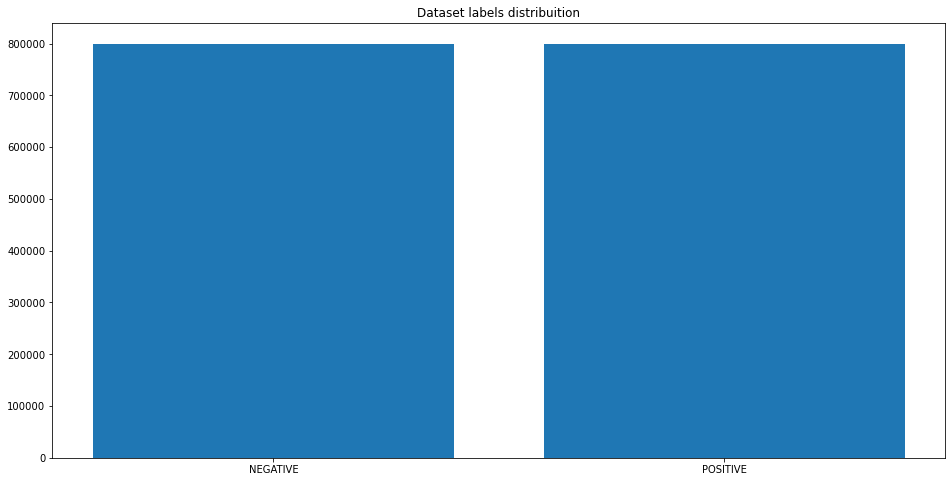

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### preprocess dataset 

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

## preprocess text 

1- remove any special character

2- convert text to lower word

3- remove stopwords

4- stem word 

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))


In [ ]:
df.head(2)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...


## drop some unuseful column 



In [ ]:
df = df.drop(['user','flag','date','ids'] , axis =1 )

In [ ]:
df.columns

Index(['target', 'text'], dtype='object')

In [ ]:
df.head(4)

,target,text
0,NEGATIVE,awww bummer shoulda got david carr third day
1,NEGATIVE,upset update facebook texting might cry result...
2,NEGATIVE,dived many times ball managed save 50 rest go ...
3,NEGATIVE,whole body feels itchy like fire


In [ ]:
df['text'][0]

'awww bummer shoulda got david carr third day'

In [ ]:
df['target'][0]

'NEGATIVE'

In [ ]:
df.isnull().sum()

target    0
text      0
dtype: int64

## split data into train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


## word2vec

In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(263118650, 295270528)

In [ ]:
w2v_model.most_similar("love")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5759313106536865),
 ('loves', 0.5573168396949768),
 ('loved', 0.5489718317985535),
 ('adore', 0.5360718369483948),
 ('amazing', 0.508001983165741),
 ('looove', 0.4830765724182129),
 ('loooove', 0.4730772376060486),
 ('awesome', 0.47215914726257324),
 ('lovee', 0.45719805359840393),
 ('loveee', 0.4423597455024719)]

### tokenize text 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    
    if word in w2v_model.wv:
        
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## build model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 548s 487ms/step - loss: 0.5033 - accuracy: 0.7512 - val_loss: 0.4631 - val_accuracy: 0.7797
Epoch 2/8
1125/1125 [==============================] - 539s 479ms/step - loss: 0.4783 - accuracy: 0.7678 - val_loss: 0.4568 - val_accuracy: 0.7839
Epoch 3/8
1125/1125 [==============================] - 538s 478ms/step - loss: 0.4722 - accuracy: 0.7719 - val_loss: 0.4518 - val_accuracy: 0.7860
Epoch 4/8
1125/1125 [==============================] - 535s 475ms/step - loss: 0.4675 - accuracy: 0.7744 - val_loss: 0.4493 - val_accuracy: 0.7876
Epoch 5/8
1125/1125 [==============================] - 536s 476ms/step - loss: 0.4653 - accuracy: 0.7759 - val_loss: 0.4492 - val_accuracy: 0.7885
Epoch 6/8
1125/1125 [==============================] - 539s 479ms/step - loss: 0.4635 - accuracy: 0.7771 - val_loss: 0.4488 - val_accuracy: 0.7893
Epoch 7/8
1125/1125 [==============================] - 541s 480ms/step - loss: 0.4619 - accuracy: 0.7781 - val_loss: 0

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 48s 153ms/step - loss: 0.4461 - accuracy: 0.7909

ACCURACY: 0.7908594012260437
LOSS: 0.4460746645927429


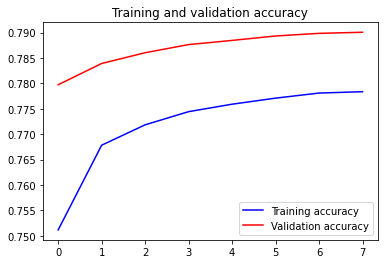

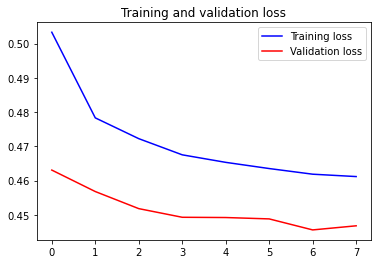

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


## predict 

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
   
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}  

In [ ]:
predict("I love the music")

{'label': 'POSITIVE', 'score': 0.9798030257225037}

In [ ]:
predict("I hate music")

{'label': 'NEGATIVE', 'score': 0.07493645697832108}

## save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

#